100%|██████████| 15/15 [00:44<00:00,  2.98s/it]


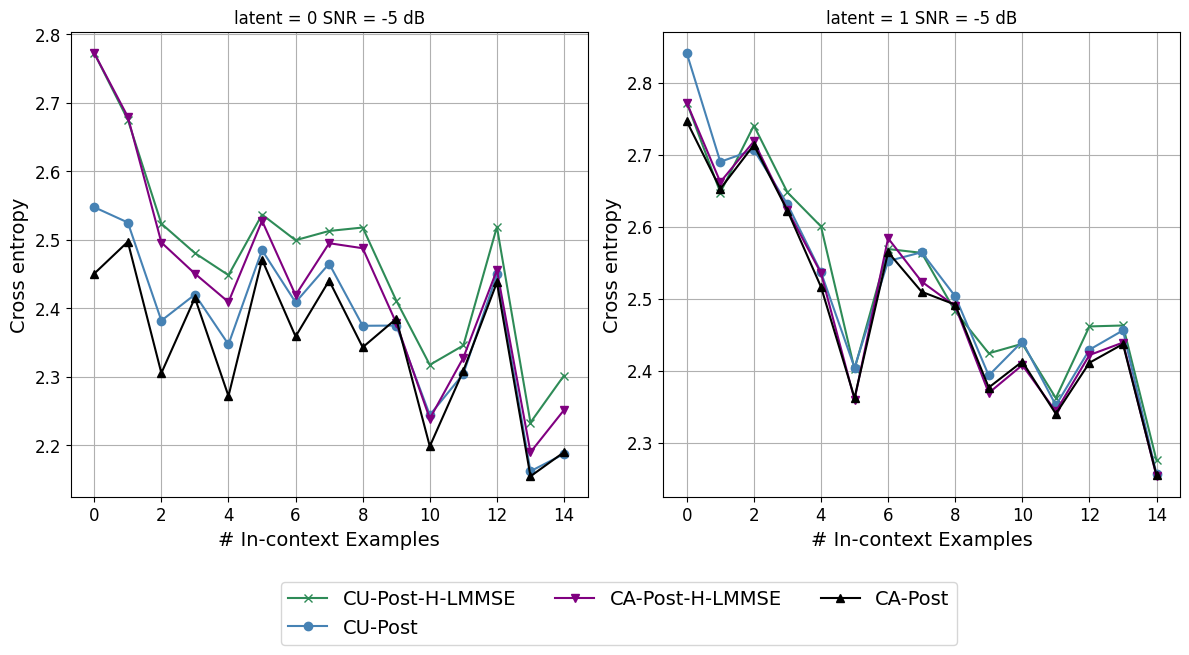

In [ ]:
# from matplotlib.patches import bbox_artist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# import torch
# import math

# def get_herm(array, axis1=-1, axis2=-2):
#     return np.conjugate(np.swapaxes(array, axis1, axis2))

def get_h_one_ray(batch_size, d):
    alphas = np.random.rand(batch_size)*np.pi
    return np.expand_dims(np.exp(-1j*np.outer(np.cos(alphas), np.arange(d))/ 2), axis=1) # (batch_size, 1, d) shape

def get_h_partition_one_ray(n_pts, d):
    return np.exp(-1j*np.outer(np.arange(d), np.cos(np.linspace(0,np.pi,n_pts)))/ 2)
    

def get_likelihoods(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=-5, 
                    latent=1, 
                    n_pts=500,
                    d=4):
    """
    :param y_past: Complex valued past output symbols of size batchsize, k, d
    :param x_past: Complex valued past input symbols of size batchsize, k, 1
    :param y_curr: Complex valued curr in symbols of size batchsize, d
    :param set_x: in symbol set (QPSK)
    SNR_dB: 1/sigma2 in dB
    latent: underlying context theta in {0, 1}
    n_pts: n_pts for numerical integral eval when latent=0
    """
    sigma2 = 10**(-snr_db/10)
    likelihood_mass = np.zeros((len(y_curr), len(set_x)))
    batch_size = len(y_curr)

    any_past = x_past.any()
    
    k = len(y_past[0]) if any_past else 0  # Number of past symbols
    
    if latent == 0:
        # Latent context is one-ray returns a alphas
        h = get_h_partition_one_ray(n_pts=n_pts, d=d)  # d_alpha for alpha corresponding to each of n_pts equally spaced points in (0, pi)
        if any_past:
            x_past = np.expand_dims(x_past, axis=3)
            y_past = np.expand_dims(y_past, axis=3)
            past_dist2 = np.sum(np.abs(y_past-x_past * h)**2, axis=(1,2))
        else:
            past_dist2 = 0
        y_curr = np.expand_dims(y_curr, axis=2)
        for idx, x_real_vec in enumerate(set_x):
            x = x_real_vec[0] + 1j* x_real_vec[1]
            x_curr = np.tile(x, (batch_size, 1, 1))
            curr_dist2 = np.sum(np.abs(y_curr-x_curr * h)**2, axis=1)
            full_dist2 = past_dist2 + curr_dist2
            likelihood_mass[:, idx] = np.sum(np.exp(-full_dist2 / (2 * sigma2)), axis=-1) / n_pts / (sigma2**(d*(k+1)))
    else:
        
        sigma_h2 = 1/2

        y_curr = np.expand_dims(y_curr, axis=1)
        if any_past:
            y_full = np.concatenate((y_past, y_curr), axis=1)
        else:
            y_full = y_curr

        # Convert to real-valued
        y_mat = complex_to_real_mat(y_full)
        y_vec = y_mat.reshape(len(y_mat), -1, 1)  # yk (batchsize, 2kd, 1)
        y_vec_t = y_vec.swapaxes(-1, -2)  # Transpose

        y_vec_dim = len(y_vec[0])

        for idx, x_real_vec in enumerate(set_x):
            x = x_real_vec[0] + 1j* x_real_vec[1]
            x_curr = np.tile(x, (batch_size, 1, 1))
            if any_past:
                x_full = np.concatenate((x_past, x_curr), axis=1)
            else:
                x_full = x_curr

            x_mat = get_in_mat(x_full, d)  # (batchsize, 2kd, 2d)  Xk
            x_mat_t = np.swapaxes(x_mat, axis1=-1, axis2=-2) # (batchsize, 2d, 2kd) Xk.T
            eye_mat = np.eye(y_vec_dim).reshape(1,y_vec_dim,-1)

            corr_y = sigma_h2 * x_mat @ x_mat_t + sigma2 * eye_mat
            corr_y_inv = np.linalg.inv(corr_y)

            likelihood_mass[:, idx] =  1 / np.sqrt(np.abs(np.linalg.det(corr_y))) * np.exp(-1/2* (y_vec_t @ corr_y_inv @ y_vec).squeeze())
    
    return likelihood_mass


def compute_context_aware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    latent=0,
                    snr_db=-5,
                    d=4):

    l_x_curr = get_likelihoods(y_curr, 
                            y_past, 
                            x_past, 
                            set_x, 
                            snr_db=snr_db, 
                            latent=latent, 
                            n_pts=500,
                            d=d)  # Compute the likelihoods for x_curr

    post_x_curr =  l_x_curr / np.expand_dims(np.sum(l_x_curr, axis=-1), axis=1)
    map_x_curr = np.argmax(post_x_curr, axis=-1)  # Maximum aposteriori estimate
    return post_x_curr


def compute_context_unaware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=-5,
                    d=4):

    p0 = p1 = 1/2

    l0_x_curr = get_likelihoods(y_curr, 
                            y_past, 
                            x_past, 
                            set_x, 
                            snr_db=snr_db, 
                            latent=0, 
                            n_pts=500,
                            d=d)
    l1_x_curr = get_likelihoods(y_curr, 
                            y_past, 
                            x_past, 
                            set_x, 
                            snr_db=snr_db, 
                            latent=1,
                            d=d)

    _post_x_curr = p0 * l0_x_curr + p1 * l1_x_curr
    post_x_curr = _post_x_curr / np.expand_dims(np.sum(_post_x_curr, axis=-1), axis=1)
    map_x_curr = np.argmax(post_x_curr, axis=-1)
    return post_x_curr


def gen_time_invariant_process(set_x,
                            latent=0,
                            max_context_len=10,
                            batch_size=100,
                            d=4,
                            snr_db=-5,
                            sigma_h2=1/2):
    """
    Generate a time invariant process

    :param set_x: The set from which input symbols are generated
    :param latent: Corresponding to which the prompt is degenerated
    :param max_context_len: Maximum context length
    :return: A tuple of         x: (batchsize, max_cnxt_ln, 1)
        y: (batchsize, max_cnxt_ln, d)
        h: (batchsize, d)
    """

    sigma2 = 10**(-snr_db/10)
    sigma = np.sqrt(sigma2)
    sigma_h = np.sqrt(sigma_h2)
    if latent==1:
        h_real, h_imag = sigma_h*np.random.randn(batch_size, 1, d), sigma_h*np.random.randn(batch_size, 1, d)
        h = h_real + 1j*h_imag
    else:
        h = get_h_one_ray(batch_size, d)
    z_real, z_imag = sigma*np.random.randn(batch_size, max_context_len, d), sigma*np.random.randn(batch_size, max_context_len, d)
    z = z_real + 1j*z_imag  
    s =  np.random.choice(len(set_x), size=(batch_size, max_context_len), replace=True)
    x_vec = set_x[s]
    x_real, x_imag = x_vec[:,:,0], x_vec[:,:,1]
    x = (x_real + 1j * x_imag).reshape(batch_size, max_context_len, 1)
    y = x * h + z
    return x, y, h.squeeze(), s  # (batchsize, max_cnxt_ln, 1) ()


def complex_to_real_mat(complex_3d):
    """
    :param complex_3d: A complex valued tensor of shape (batch_size, context_len, d)
    """
    batch_size, n_symbols, _ = complex_3d.shape
    vec_real = np.expand_dims(np.real(complex_3d), axis=2) # batch_size, context_len, 1, d
    vec_imag = np.expand_dims(np.imag(complex_3d), axis=2) # batch_size, context_len, 1, d
    return np.concatenate((vec_real, vec_imag), axis=2).reshape(batch_size, n_symbols, -1) # batch_size, context_len, 2d


def get_in_mat(x, d):
    """
    :param x: complex valued input symbs of (batch_size, context_len, 1)

    """
    x_real = np.real(x).squeeze(-1)
    x_imag = np.imag(x).squeeze(-1)
    tmp_mat = np.zeros((x.shape[0], 2 * x.shape[1], 2))
    tmp_mat[:, 0::2, 0] = x_real
    tmp_mat[:, 0::2, 1] = -1*x_imag
    tmp_mat[:, 1::2, 0] = x_imag
    tmp_mat[:, 1::2, 1] = x_real
    x_mat = np.kron(tmp_mat, np.eye(d))  # (batch_size, 2kd, 2d)
    return x_mat


def compute_context_unaware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    mean_h,
                    corr_h,
                    set_x, 
                    snr_db=-5,
                    d=4):

    any_past = y_past.any()
    batch_size = len(y_curr)

    if any_past:
        h_lmmse = compute_lmmse(y_past,
                x_past,
                mean_h,
                corr_h,
                snr_db=snr_db,
                n_pts=500,
                d=d)
    else:
        mean_h_vec = np.tile(mean_h, (batch_size, 1))
        h_lmmse = mean_h_vec[:,:d] + 1j* mean_h_vec[:,d:]
    
    post_x_curr_from_est = compute_posterior_from_estimate(y_curr, h_est=h_lmmse, set_x=set_x, snr_db=snr_db)  # Compute posterior for the channel estimate
    map_x_curr_from_est = np.argmax(post_x_curr_from_est, axis=-1)
    return post_x_curr_from_est



def compute_lmmse(y_past,
                x_past,
                mean_h,
                corr_h,
                snr_db=-5,
                n_pts=500,
                d=4):
    """
    past_out_symbs: complex valued past out symbols of size batchsize, k, d
    past_in_symbs: complex valued past in symbols of size batchsize, k, 1
    curr_out: complex valued curr in symbols of size batchsize, d
    mean_h: 2d real vec
    corr_h: 2dx2d real matrix for [hI, hQ] -> 2d real vec
    X: in symbol set (QPSK)
    """

    sigma2 = 10**(-snr_db/10)
    

    # Convert to real-valued vectors
    y_mat = complex_to_real_mat(y_past)
    y_vec = y_mat.reshape(len(y_mat), -1, 1)  # yk (batch_size, 2kd, 1)
    x_mat = get_in_mat(x_past, d)  # (batch_size, 2kd, 2d)  Xk
    x_mat_t = np.swapaxes(x_mat, axis1=-1, axis2=-2) # (batch_size, 2d, 2kd)

    y_vec_dim = len(y_vec[0])
    batch_size = len(y_vec)

    corr_h = np.tile(corr_h, (batch_size, 1, 1))
    eye_mat = np.eye(y_vec_dim).reshape(1,y_vec_dim,-1)

    corr_y = x_mat @ corr_h @ x_mat_t + sigma2 * eye_mat
    corr_hy = corr_h @ x_mat_t

    mean_y = x_mat @ mean_h
    mean_y_vec = np.expand_dims(mean_y, axis=-1)
    mean_y_vec_t = mean_y_vec.swapaxes(-1, -2)

    mean_h_vec = mean_h.reshape(1,-1, 1)
    
    cov_y = corr_y - mean_y_vec @ mean_y_vec_t
    cov_y_inv = np.linalg.inv(cov_y)
    cov_hy = corr_hy - mean_h_vec @ mean_y_vec_t
    h_lmmse = mean_h + cov_hy @ cov_y_inv @ (y_vec - mean_y_vec)

    return h_lmmse[:,:d,0] + 1j * h_lmmse[:,d:,0]


def compute_posterior_from_estimate(y, h_est, set_x, snr_db=-5):
    """
    Compute the posterior distribution of x in y=hx+z, where h_est is used for h.

    :param y: Complex valued symbols (batch_size, d)
    :param h_est: Complex valued channel estimate (batch_size, d)
    :param set_x: Input symbol set (QPSK)
    :param snr_db: SNR in dB

    :return: Posterior mass (batch_size, len(set_x))
    """
    sigma2 = 10**(-snr_db/10)
    batch_size = len(y)
    post_mass = np.zeros((batch_size, len(set_x)))
    for idx, x_real_vec in enumerate(set_x):
        curr_in = x_real_vec[0] + 1j* x_real_vec[1]
        sq_dist_curr_symb = np.sum(np.abs(y-curr_in * h_est)**2, axis=-1)
        post_mass[:, idx] = np.exp(-sq_dist_curr_symb/2/sigma2)
    post_x = post_mass / np.expand_dims(np.sum(post_mass, axis=-1), axis=-1)
    return post_x


# Get a QAM constellation of size M
def get_qam_constellation(set_size=4):
    """
    Get a QAM constellation of size M.

    :param set_size: Size of the QAM constellation
    :return: QAM constellation of the specified size
    """
    set_size_real = int(np.sqrt(set_size))
    set_size_imag = set_size_real

    x_real_vec = np.linspace(-2*set_size_real+1, 2*set_size_real-1, set_size_real)
    x_imag_vec = x_real_vec
    x_real, x_imag = np.meshgrid(x_real_vec, x_imag_vec)

    x = x_real + 1j * x_imag  # Complex set of symbols

    # Normalize the energy to 1
    x = x / np.sqrt(np.mean(np.abs(x)**2))

    # Stack to get real and imaginary parts of the symbols (set_size, 2)
    x_vec = np.stack((np.real(x).ravel(), np.imag(x).ravel()), axis=-1)
    return x_vec


# Get QPSK constellation
def get_qpsk_constellation():
    """
    Get a QPSK constellation of size M.

    :param set_size: Size of the QPSK constellation
    :return: QPSK constellation of the specified size
    """
    x_vec = np.array([[1, 1],[1, -1],[-1, 1],[-1, -1]])
    return x_vec


# Plotting utils

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color='darkred',
        marker='s',
        linewidth=2,
        markersize=4,
        legend=False
    )


# # Load the transformer results
# ce_tf_0 = np.load('../results/CE_one_ray_tf_detection_time_invariant_snr_neg5.npy')
# ce_tf_1 = np.load('../results/CE_fading_tf_detection_time_invariant_snr_neg5.npy')


signal_type = 'qam'

if signal_type == 'qpsk':
    set_x = get_qpsk_constellation()
elif signal_type == 'qam':
    set_x_size = 16
    set_x = get_qam_constellation(set_size=set_x_size)
else:
    raise ValueError("Invalid signal type")


# Compute the statistics of h
sigma_h2 = 1/2
p0 = p1 = 1/2
d = 4
snr_db = -5 
max_context_len = 15
n_samples = 100

# Compute the mean and corr of h for latent=0
n_points = 500
h_complex_points = get_h_partition_one_ray(n_pts=n_points,d=d)  # d, n_pts
h_points_real, h_points_imag = np.real(h_complex_points), np.imag(h_complex_points) # d, n_pts
h_points = np.concatenate((h_points_real, h_points_imag), axis=0)
mean_h0 = np.mean(h_points, axis=-1)
corr_h0 = h_points @ h_points.T / n_points

# Compute the mean and corr of h for latent=1
mean_h1 = mean_h0 = np.zeros(2*d)  # Set mean_h0 to 0
corr_h1 = sigma_h2 * np.eye(2*d)

mean_h = p0 * mean_h0 + p1 * mean_h1
corr_h = p0 * corr_h0 + p1 * corr_h1


# Generate the data
latent = 0
x, y, h, s = gen_time_invariant_process(set_x=set_x,
                                batch_size=n_samples,
                                latent=latent,
                                snr_db=snr_db,
                                max_context_len=max_context_len,
                                d=d)

if latent == 0:
    mean_h_true = mean_h0
    corr_h_true = corr_h0
else:
    mean_h_true = mean_h1
    corr_h_true = corr_h1

ce_cu_post_lmmse = np.zeros(len(x[0]))
ce_ca_post_lmmse = np.zeros(len(x[0]))
ce_cu_post = np.zeros(len(x[0]))
ce_ca_post = np.zeros(len(x[0]))


for k in tqdm(range(max_context_len)):
    y_curr = y[:,k,:]
    x_curr = x[:,k,0]
    y_past = y[:,:k,:]
    x_past = x[:,:k,:]
    s_curr = s[:, k]
    cu_post = compute_context_unaware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=snr_db)
    ca_post = compute_context_aware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    latent=latent,
                    snr_db=snr_db)
    cu_post_lmmse = compute_context_unaware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    mean_h,
                    corr_h,
                    set_x, 
                    snr_db=snr_db)
    ca_post_lmmse = compute_context_unaware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    mean_h_true,
                    corr_h_true,
                    set_x, 
                    snr_db=snr_db)  # Takes true channel stats

    ce_cu_post_lmmse[k] = -np.mean(np.log(cu_post_lmmse[np.arange(n_samples), s_curr]))
    ce_ca_post_lmmse[k] = -np.mean(np.log(ca_post_lmmse[np.arange(n_samples), s_curr]))
    ce_cu_post[k] = -np.mean(np.log(cu_post[np.arange(n_samples), s_curr]))
    ce_ca_post[k] = -np.mean(np.log(ca_post[np.arange(n_samples), s_curr]))


np.save(f'../results/ce_cu_post_lmmse_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post_lmmse)
np.save(f'../results/ce_ca_post_lmmse_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_ca_post_lmmse)
np.save(f'../results/ce_cu_post_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post)
np.save(f'../results/ce_ca_post_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_ca_post)


fig, axs = plt.subplots(1, 2, figsize=(6*2, 6), sharex=True)

axs[0].plot(ce_cu_post_lmmse, label='CU-Post-H-LMMSE', color='seagreen', marker='x')
axs[0].plot(ce_cu_post, label='CU-x-MSE', color='steelblue', marker='o')
axs[0].plot(ce_ca_post_lmmse, label='CA-xh-MSE', color='purple', marker='v')
axs[0].plot(ce_ca_post, label='CA-Post', color='black', marker='^')

# lineplot_with_ci(ce_tf_0[:, :max_context_len],
#         n_points=max_context_len,
#         offset=0,
#         label="Transformer",
#         ax=axs[0])

# axs[0].plot(np.mean(tf_SEP_0, axis=0), label='Transformer', color='darkred', marker='s')
axs[0].set_title(f'latent = {latent} SNR = {snr_db} dB')
axs[0].grid()
# axs[0].set_ylim([-5,105])

# plt.savefig('Figures/SEP_snr_neg5_time_invariant_one_ray.png', dpi=400, bbox_inches='tight')




latent = 1

x, y, h, s = gen_time_invariant_process(set_x=set_x,
                                batch_size=n_samples,
                                latent=latent,
                                snr_db=snr_db,
                                max_context_len=max_context_len,
                                d=d)


ce_cu_post_lmmse_1 = np.zeros(len(x[0]))
ce_ca_post_lmme_1 = np.zeros(len(x[0]))
ce_cu_post_1 = np.zeros(len(x[0]))
ce_ca_post_1 = np.zeros(len(x[0]))

if latent == 0:
    mean_h_true = mean_h0
    corr_h_true = corr_h0
else:
    mean_h_true = mean_h1
    corr_h_true = corr_h1


for k in tqdm(range(max_context_len)):
    y_curr = y[:,k,:]
    x_curr = x[:,k,0]
    s_curr = s[:, k]
    y_past = y[:,:k,:]
    x_past = x[:,:k,:]
    cu_post = compute_context_unaware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=snr_db,
                    d=d)
    ca_post = compute_context_aware_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    latent=latent,
                    snr_db=snr_db,
                    d=d)
    cu_post_lmmse = compute_context_unaware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    mean_h,
                    corr_h,
                    set_x, 
                    snr_db=snr_db)
    ca_post_lmmse = compute_context_unaware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    mean_h_true,
                    corr_h_true,
                    set_x, 
                    snr_db=snr_db)

    ce_cu_post_lmmse_1[k] = -np.mean(np.log(cu_post_lmmse[np.arange(n_samples), s_curr]))
    ce_ca_post_lmme_1[k] = -np.mean(np.log(ca_post_lmmse[np.arange(n_samples), s_curr]))
    ce_cu_post_1[k] = -np.mean(np.log(cu_post[np.arange(n_samples), s_curr]))
    ce_ca_post_1[k] = -np.mean(np.log(ca_post[np.arange(n_samples), s_curr]))


np.save(f'../results/ce_cu_post_lmmse_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post_lmmse_1)
np.save(f'../results/ce_ca_post_lmmse_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_ca_post_lmme_1)
np.save(f'../results/ce_cu_post_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post_1)
np.save(f'../results/ce_ca_post_lat_{latent}_{signal_type}_snr_db{snr_db}.npy', ce_ca_post_1)


axs[1].plot(ce_cu_post_lmmse_1, label='CU-Post-H-LMMSE', color='seagreen', marker='x')
axs[1].plot(ce_cu_post_1, label='CU-Post', color='steelblue', marker='o')
axs[1].plot(ce_ca_post_lmme_1, label='CA-Post-H-LMMSE', color='purple', marker='v')
axs[1].plot(ce_ca_post_1, label='CA-Post', color='black', marker='^')
# axs[1].plot(np.mean(tf_SEP_1, axis=0), label='Transformer', color='darkred', marker='s')

# lineplot_with_ci(ce_tf_1[:, :max_context_len],
#         n_points=max_context_len,
#         offset=0,
#         label="Transformer",
#         ax=axs[1])

axs[1].set_title(f'Latent = {latent} SNR = {snr_db} dB')
axs[1].grid()


for ax in axs:
    ax.set_xlabel("# In-context Examples", fontsize=14)
    ax.set_ylabel("Cross entropy", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'../plots/ce_time_invar_{signal_type}_snr_db{snr_db}.png', dpi=400, bbox_inches='tight')


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl

import matplotlib.pyplot as plt

# Plotting

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, color='darkred', lw=2):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color=color,
        linewidth=lw,
        markersize=4,
        legend=False
    )


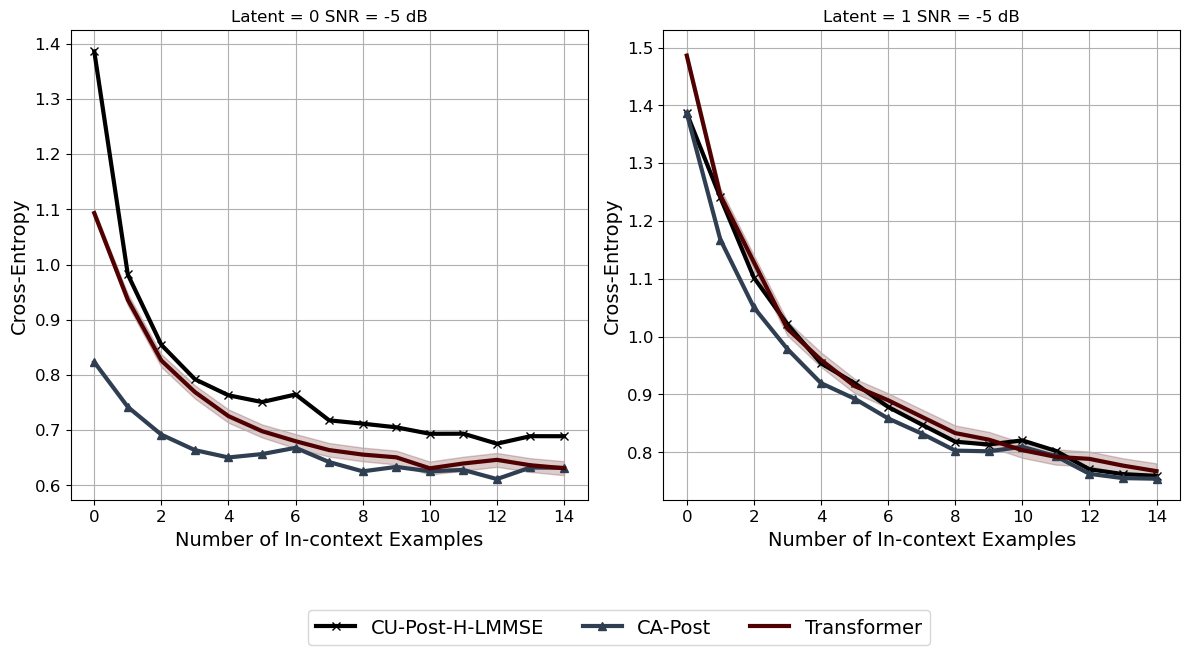

In [ ]:
# colors = sns.color_palette("husl", 8)

# colors = mpl.colormaps['Dark2'].colors

# colors = ['#55AA6A', '#556BAA', '#AA9455']

snr_db = -5

darkblue =  '#2F3E51'
darkred = '#500000'

lightblue = '#AEB7CF'
customgray = '#707070'

tan = "#D6D3C4"


colors = ['k', darkblue,  darkred]

lws = [3, 3, 3]

# Load the files

ce_cu_post_lmmse = np.load('../Files/CU_xh_MSE_snr_neg5.npy')
# CA_xh_MSE = np.load('../Files/CA_xh_MSE_snr_neg5.npy')
# CU_x_MSE = np.load('../Files/CU_x_MSE_snr_neg5.npy')
ce_ca_post = np.load('../Files/CA_x_MSE_snr_neg5.npy')

ce_cu_post_lmmse_1 = np.load('../Files/CU_xh_MSE1_snr_neg5.npy')
# CA_xh_MSE1 = np.load('../Files/CA_xh_MSE1_snr_neg5.npy')
# CU_x_MSE1 = np.load('../Files/CU_x_MSE1_snr_neg5.npy')
ce_ca_post_1 = np.load('../Files/CA_x_MSE1_snr_neg5.npy')

ce_tf_0 = np.load('../Files/CE_one_ray_tf_detection_time_invariant_snr_neg5.npy')
tf_CE_1 = np.load('../Files/CE_fading_tf_detection_time_invariant_snr_neg5.npy')

max_context_len = len(ce_cu_post_lmmse)


fig, axs = plt.subplots(1, 2, figsize=(6*2, 6), sharex=True)


axs[0].plot(ce_cu_post_lmmse, label='CU-Post-H-LMMSE', color=colors[0], marker='x', lw=lws[0])
# axs[0].plot(CU_x_MSE, label='CU-x-MSE', color='steelblue', marker='o')
# axs[0].plot(CA_xh_MSE, label='CA-xh-MSE', color='seagreen', marker='x')
axs[0].plot(ce_ca_post, label='CA-Post', color=colors[1], marker='^', lw=lws[1])

lineplot_with_ci(ce_tf_0,
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[0], color=colors[2], lw=lws[2])

# axs[0].plot(np.mean(tf_SEP_0, axis=0), label='Transformer', color='darkred', marker='s')
axs[0].set_title(f'Latent = 0 SNR = {snr_db} dB')
axs[0].grid()


# plt.close()

axs[1].plot(ce_cu_post_lmmse_1, label='CU-Post-H-LMMSE', color=colors[0], marker='x', lw=lws[0])
# plt.plot(CU_x_MSE1, label='CU-x-MSE', color='steelblue', marker='o')
# plt.plot(CA_xh_MSE1, label='CA-xh-MSE', color='seagreen', marker='x')
axs[1].plot(ce_ca_post_1, label='CA-Post', color=colors[1], marker='^', lw=lws[1])
# axs[1].plot(np.mean(tf_SEP_1, axis=0), label='Transformer', color='darkred', marker='s')

lineplot_with_ci(tf_CE_1,
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[1], color=colors[2], lw=lws[2])

axs[1].set_title(f'Latent = 1 SNR = {snr_db} dB')
# axs[1].set_ylim([-5,105])
axs[1].grid()


for ax in axs:
    ax.set_xlabel("Number of In-context Examples", fontsize=14)
    ax.set_ylabel("Cross-Entropy", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.set_facecolor('whitesmoke')

lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/CE_snr_neg5_qpsk_time_invariant.png', dpi=400, bbox_inches='tight')

In [ ]:
import numpy as np

A = np.random.randint(10, size=(10, 3))
B = np.random.randint(3, size=(10,))
result = A[np.arange(A.shape[0]), B]

print('A = ', A)
print('B = ', B)
print('Res = ',  result)